In [ ]:
include("../src/ParamsFunctions.jl")
include("../src/ParamsFunctionsLCDM.jl")
include("../src/TransferFunction.jl")
import .ParamsFunctions as PF
import .ParamsFunctionsLCDM as PFL
import .TransferFunction as TF
using Plots

# Non-local 21cm Julia package
---
In this presentation we will showcase our code related to our work on 21cm power spectrum of LLNL cosmology.<br>
Our package includes numerical solvers for the field equation, power spectrum, transfer function, sigma 8, halo and 21cm bias, and density contrast.<br>
Parameters can be easily modified to obtain different models and adjust the strength of non-local effects.

### Parameters
---

We chose our parameters from "Planck 2018" and "Tabatabaei 2023 - LLNL: cosmological perturbations". <br>
Nonlocal Parameters: <br>
$\alpha = 0.0034$, $\beta = -1$ and $S(z) = \alpha (1 + z)^\beta$

### Field Equations
---
$$
 \phi' + (\frac{k^2}{3\mathcal{H}}+\mathcal{H}+\frac{1}{2}\mathcal{B})\phi = \frac{\kappa a^2}{6(1+\bar{S})\mathcal{H}}\delta\rho = \frac{\mathcal{H} \rho_m}{2 \rho} \delta 
$$
$$
 \phi'' + (3\mathcal{H}+\mathcal{B})\phi' - (3w\mathcal{H}^2 + 3w\mathcal{H}\mathcal{B} +2\mathcal{B}^2)\phi + 2\mathcal{H}\frac{\delta S'}{1+\bar{S}} =0
$$
The second equation is solved by DifferentialEquations.jl ODE solver in reverse from $z=100$ to $z=0$ (or any other z). <br>
Since non-local effects are miniscule at $z=100$ the initial conditions of $\phi$ are calculated using $D$ and $D'$ (density contrast for $\Lambda \text{CDM}$) at $z=100$.<br>
Different values of $k$ can also be given to the function.

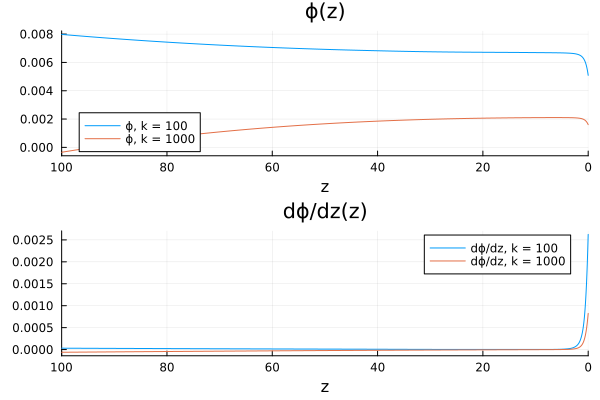

In [4]:
PF.plot_phi(100)
PF.plot_phi!(1000)

### Density Contrast
---
Using $\phi$ and $\phi'$ we can calculate the density contrast of both non-local and $\Lambda \text{CDM}$ models.

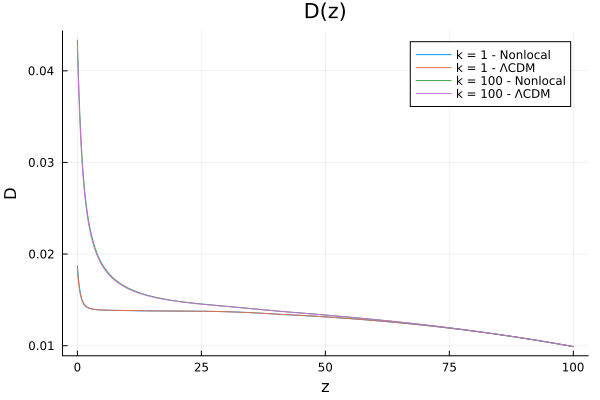

In [6]:
PF.plot_d(1)
PFL.plot_d_LCDM!(1)
PF.plot_d!(100)
PFL.plot_d_LCDM!(100)

The ratio of density contrast of the two models can also be plotted

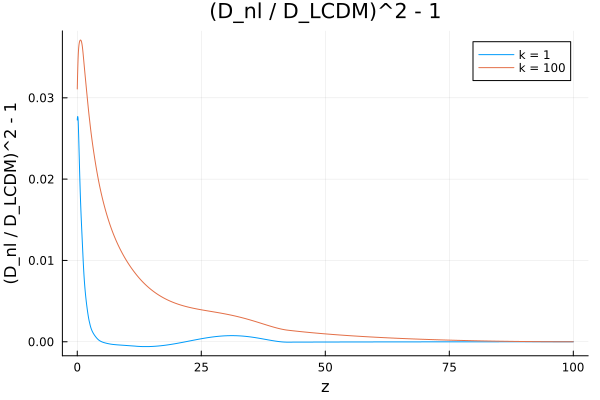

In [14]:
k = 1
z_nl, d_nl = PF.d_solve(k)
z_LCDM, d_LCDM = PFL.d_solve_LCDM(k)
d_ratio = (d_nl ./ d_LCDM) .^ 2 .- 1
plot(z_nl, d_ratio, title = "(D_nl / D_LCDM)^2 - 1", label = "k = $k", xlabel = "z", ylabel = "(D_nl / D_LCDM)^2 - 1")
k = 100
z_nl, d_nl = PF.d_solve(k)
z_LCDM, d_LCDM = PFL.d_solve_LCDM(k)
d_ratio = (d_nl ./ d_LCDM) .^ 2 .- 1
plot!(z_nl, d_ratio, title = "(D_nl / D_LCDM)^2 - 1", label = "k = $k", xlabel = "z", ylabel = "(D_nl / D_LCDM)^2 - 1")

### Transfer Function
---
We used the Eisenstein-Hu transfer function throughout our code. <br>
This module is a direct port of a c++ module by Farbod Hassani.

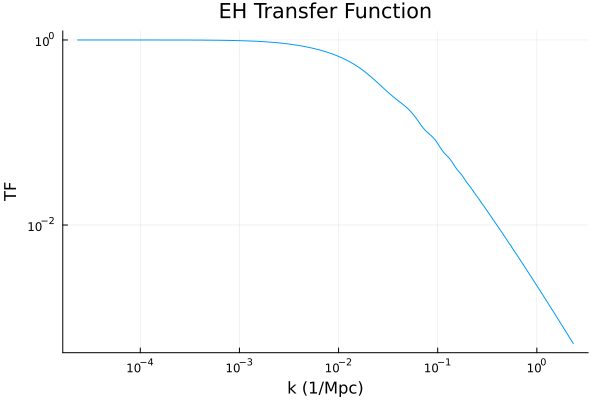

In [15]:
Omega_r = 0
h = 0.7
Omega_c = 0.112 / h ^ 2
Omega_b = 0.0226 / h ^ 2
Omega_l = 1 - 0.317
CMB_temp = 2.726

k_order_min = -1.0
k_order_max = 4.0
data_count = 1000
k_range = 10 .^ range(k_order_min, stop = k_order_max, length=data_count)
k_range = k_range .* PF.H_nonlocal(0) ./ (3 * 10^5)

TF_array = TF.Tk_EH_full.(k_range, Omega_r , Omega_c, Omega_b, Omega_l, h, CMB_temp)
plot(k_range, TF_array, xaxis = :log, yaxis = :log, xlabel = "k (1/Mpc)", ylabel = "TF", title = "EH Transfer Function", legend = false)

## Power Spectrum
---
Using the growth function and EH transfer function we calculated, we can obtain the non-local power spectrum <br>
using the equation below:
$$
LLNL \quad PS = A \; {T_{EH}}(k) ^ 2 \; D(k,z) ^ 2 
$$

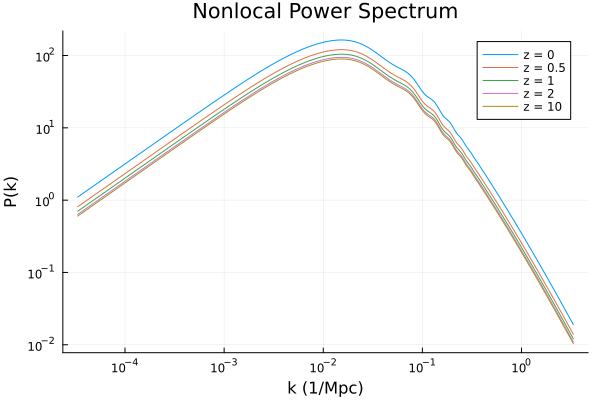

In [25]:
PF.power_spectrum_plot(-1.0, 4.0, 0)
PF.power_spectrum_plot!(-1.0, 4.0, 0.5)
PF.power_spectrum_plot!(-1.0, 4.0, 1)
PF.power_spectrum_plot!(-1.0, 4.0, 2)
PF.power_spectrum_plot!(-1.0, 4.0, 10)

The resulting power spectrum can be multiplied by a constant value so we fix this value <br>
by calculating $\sigma$ with regards to $R$. <br>
But first we can fix the max value of the non-local power spectrum, with the one obtained from CAMB <br>
to illustrate the non-local effects.

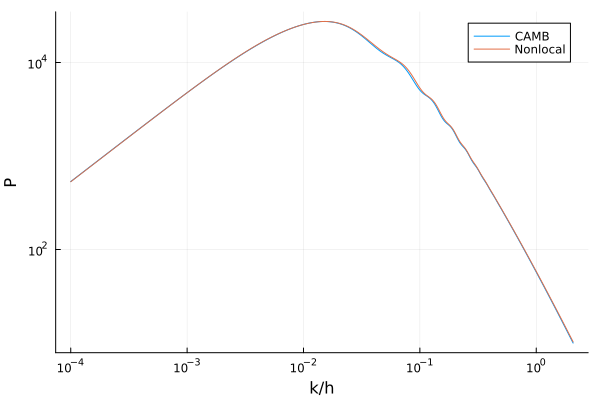

In [26]:
PF.PS_ratio_plot()

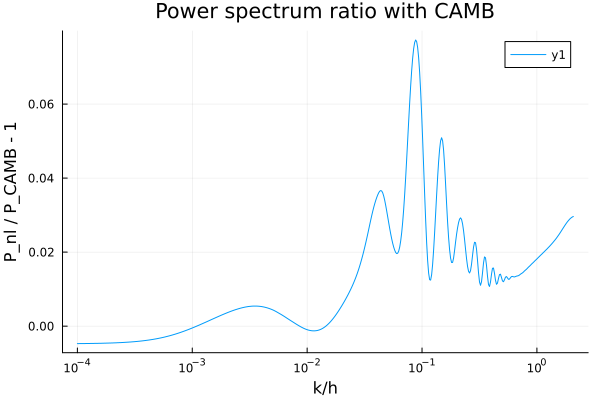

In [27]:
PF.PS_ratio_ratio_plot()

## $\sigma_8$ Fixing
---
First $\sigma_8$ is calculated with regards to $R$ using the formula below: (at z=0)
$$
\sigma^2(R) = \int \frac{1}{2 \pi ^2} (\frac{k}{h})^2 P(k) W^2(k \cdot R) dk
$$
where $W(x)$ is a window function defined as:
$$
W(x) = 3 \frac{\sin(x) - x \cos(x)}{x^3}
$$
The integration is done numerically using the Integrals.jl package and the trapezoidal rule method.<br>
An important consideration is that until now our power spectrum was calculated with equal logarithmic distribution <br>
which causes issues with numerical integration methods. Thus, another power spectrum should be calculated with linear <br>
distribution of scale which will integrated to plot $\sigma(R)$. <br>
<br>
After calculating $\sigma$ for the non-local power spectrum, we fix $\sigma_8$ with the $\Lambda \text{CDM}$ value calculated in the <br>
same manner. The scaled power spectrum will have the correct order of magnitude.

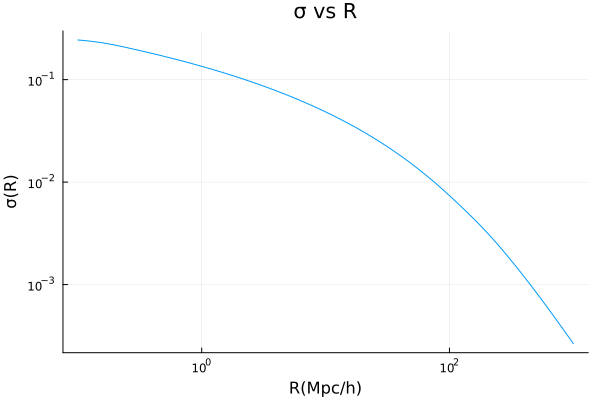

In [30]:
PF.PS_integrate_plot("../../Data/Nonlocal Power Spectrum.csv")

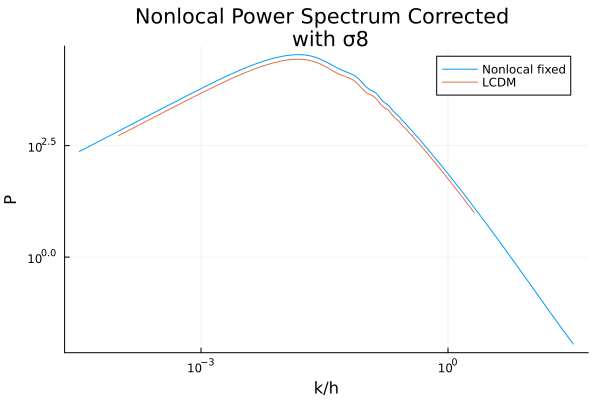

In [31]:
PF.PS_fix_sigma8("../../Data/Nonlocal Power Spectrum.csv")
PF.PS_fixed_sigma8_plot("../../Data/Nonlocal_powerspectrum_sigma8.csv")

## Bias
---
As was discussed in a previous research group meeting, the Press-Schechter bias is defined as:
$$
\begin{align*}
b &= 1 + \frac{\nu^2 - 1}{\delta_c} \\
\nu &= \frac{\delta_c}{\sigma(R)}
\end{align*}
$$
$R$ can be calculated by knowing tracer mass and density.
$$
R = \left(  \frac{3 M}{4 \pi \rho}  \right) ^ {(\frac{1}{3})}
$$
The biased power spectrum is calculated as below:
$$
P_{Halo} = b^2 \; P_M
$$

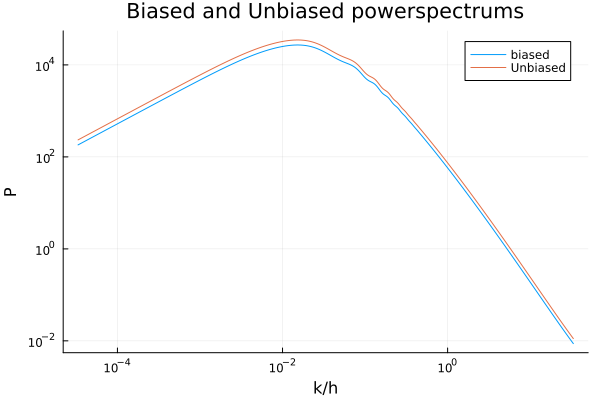

In [46]:
PF.PS_bias_applied_compare("../../Data/Nonlocal_powerspectrum_sigma8.csv", 0, 10.0^13)

## Summary
---
Through out this project we developed a piece of code that provides useful checks and numerical solutions for the non-local gravity model. <br>
In this presentation we displayed our work for LLNL. The parameters and functions can be easily modified to generate results for new models. 